In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [3]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/6CS012 AI & ML/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/drive/MyDrive/6CS012 AI & ML/DevanagariHandwrittenDigitDataset/Test"
# Define image size
img_height, img_width = 28, 28
# Function to load images and labels using PIL
def load_images_from_folder(folder):
  images = []
  labels = []
  class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
  class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
  for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    label = class_map[class_name]
    for filename in os.listdir(class_path):
      img_path = os.path.join(class_path, filename)
      # Load image using PIL
      img = Image.open(img_path).convert("L") # Convert to grayscale
      img = img.resize((img_width, img_height)) # Resize to (28,28)
      img = np.array(img) / 255.0 # Normalize pixel values to [0,1]

      images.append(img)
      labels.append(label)
  return np.array(images), np.array(labels)
# Load training and testing datasets
train_x, train_y = load_images_from_folder(train_dir)
test_x, test_y = load_images_from_folder(test_dir)

In [4]:
def shuffle_data(clean_images, noisy_images_low=None, noisy_images_high=None, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate shuffled indices
    num_samples = clean_images.shape[0]
    indices = np.random.permutation(num_samples)

    # Apply indices to shuffle arrays
    shuffled_clean = clean_images[indices]
    shuffled_noisy_low = noisy_images_low[indices] if noisy_images_low is not None else None
    shuffled_noisy_high = noisy_images_high[indices] if noisy_images_high is not None else None

    return (
        shuffled_clean,
        shuffled_noisy_low if noisy_images_low is not None else None,
        shuffled_noisy_high if noisy_images_high is not None else None
    )

# Example integration with your code
# Assuming x_train, x_test, etc., are already defined as in your code
# x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
#     x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
# )
# x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
#     x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
# )

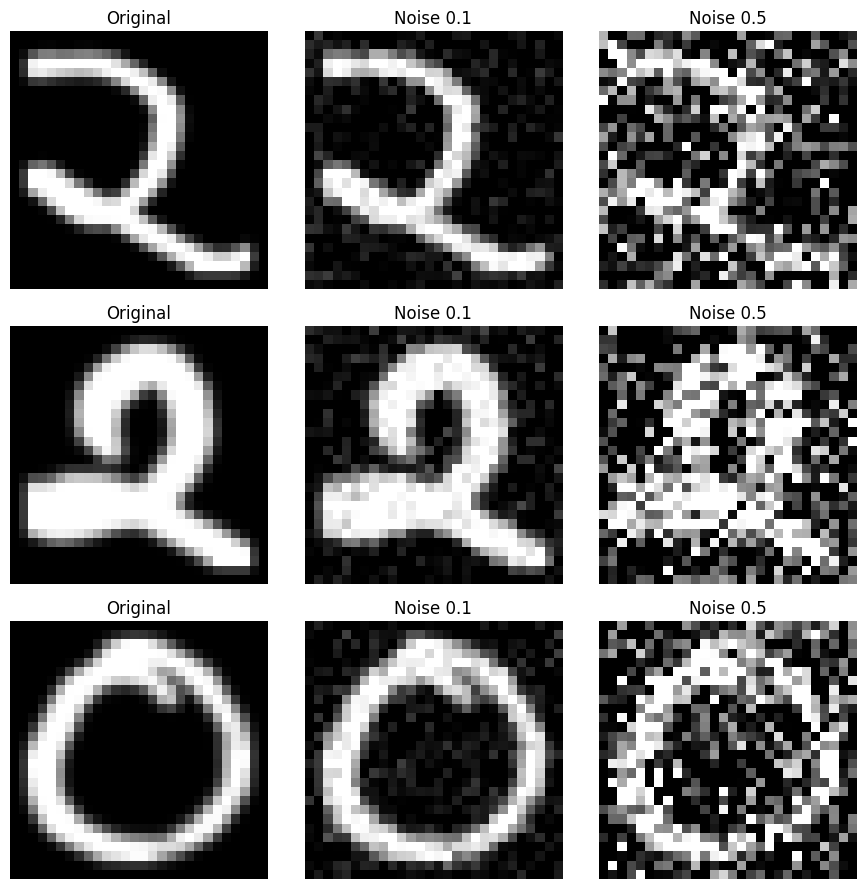

In [5]:

# Load and preprocess MNIST
x_train, x_test = train_x, test_x
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)


x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
    x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
)
x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
    x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
)


#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))  # Update to (32, 32, 1) if Devnagari uses 32x32
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [7]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.4904 - val_loss: 0.2358
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2289 - val_loss: 0.2152
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2136 - val_loss: 0.2072
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2068 - val_loss: 0.2017
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2016 - val_loss: 0.1987
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1989 - val_loss: 0.1968
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1969 - val_loss: 0.1956
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1957 - val_loss: 0.1943
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1943 - val_loss: 0.1933
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1935 - val_loss: 0.1925


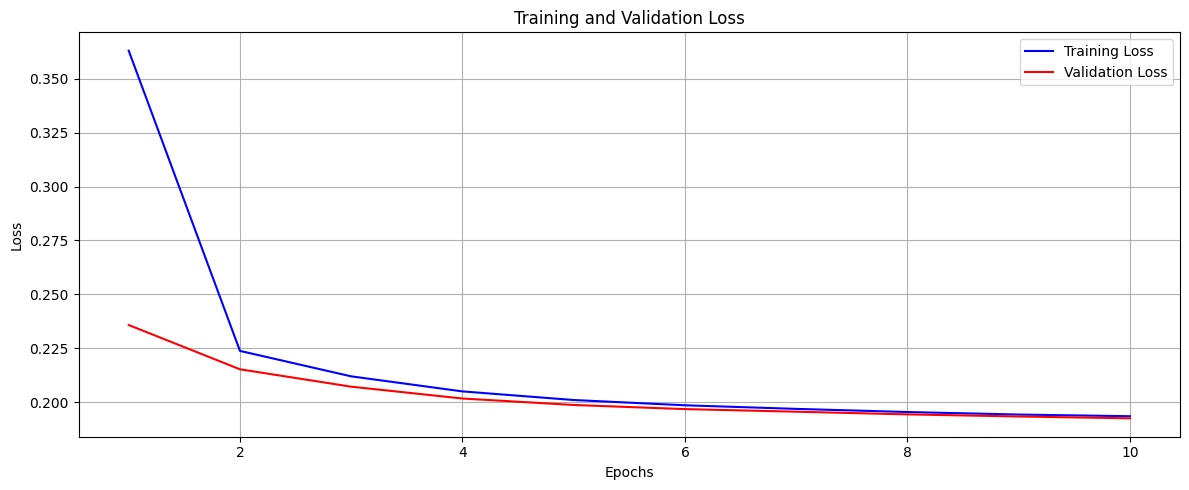

In [8]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


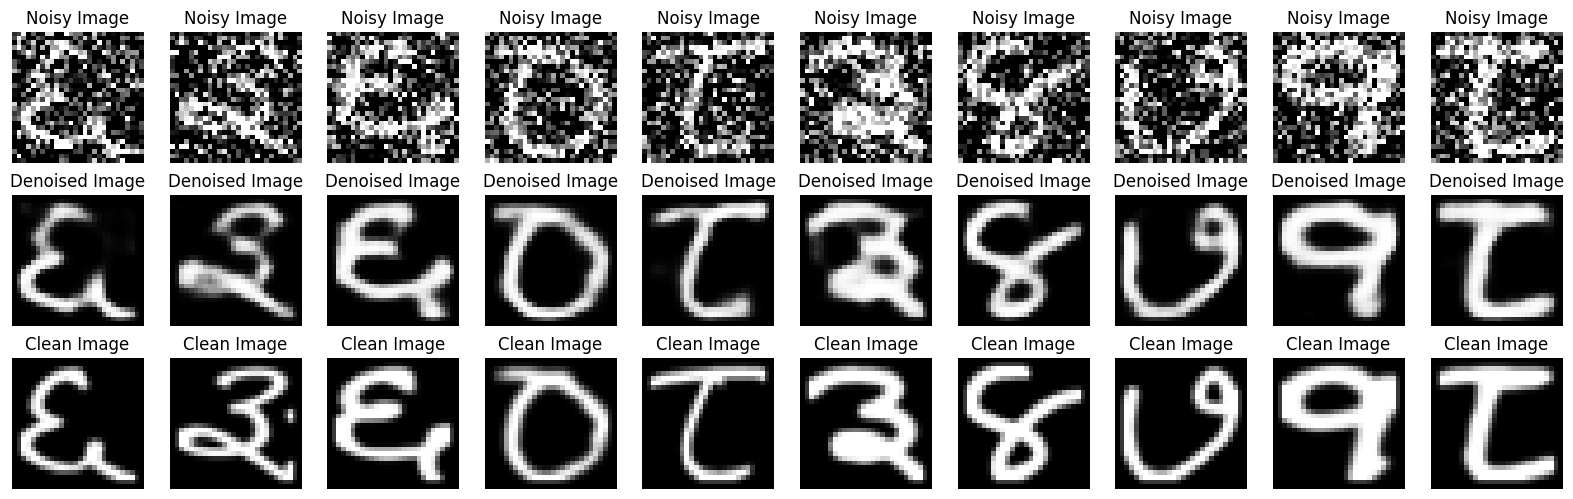

In [9]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
  # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)